This notebook is for training the network for CIFAR10 dataset using a network with stochastic binarization.

In [1]:
%env THEANO_FLAGS=floatX=float32, device=gpu3
import numpy as np
import theano
import theano.tensor as T 
import lasagne
from __future__ import print_function
import BC_layers
import BC_utils
from pylearn2.datasets.zca_dataset import ZCA_Dataset
from pylearn2.utils import serial
import timeit
import inspect
import time
import logging
from lasagne.layers import batch_norm

env: THEANO_FLAGS=floatX=float32, device=gpu3


Using gpu device 3: GeForce GTX TITAN X (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 4004.)


The original implementation use a script for pre-processing. I also found preprocessing script [here](https://github.com/lisa-lab/pylearn2/blob/master/pylearn2/scripts/papers/maxout/svhn_preprocessing.py), and it seems that it is from the codes for Maxout Network. So here in order to make sure I have the same preprocessing result, I use the same code in the link.

Moreover, the code for downloading and splitting the data is from [here](https://raw.githubusercontent.com/lisa-lab/pylearn2/master/pylearn2/scripts/datasets/download_svhn.sh), also in the pylearn2 library. Although we can also use the code in the previous homeworks, here I use that code for consistency of the overall training.

In [2]:
# make logging functions

logger = logging.getLogger('')
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler('experiment.log')
fh.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(message)s')
ch.setFormatter(formatter)
fh.setFormatter(formatter)
logger.addHandler(ch)
logger.addHandler(fh)

Again, here I use the same code to load the data.

In [3]:
train_set_size = 45000
    
print('Loading CIFAR-10 dataset...')
    
preprocessor = serial.load("${PYLEARN2_DATA_PATH}/cifar10/pylearn2_gcn_whitened/preprocessor.pkl")

train_set = ZCA_Dataset(
    preprocessed_dataset=serial.load("${PYLEARN2_DATA_PATH}/cifar10/pylearn2_gcn_whitened/train.pkl"), 
    preprocessor = preprocessor,
    start=0, stop = train_set_size)

valid_set = ZCA_Dataset(
    preprocessed_dataset= serial.load("${PYLEARN2_DATA_PATH}/cifar10/pylearn2_gcn_whitened/train.pkl"), 
    preprocessor = preprocessor,
    start=45000, stop = 50000)  
    
test_set = ZCA_Dataset(
    preprocessed_dataset= serial.load("${PYLEARN2_DATA_PATH}/cifar10/pylearn2_gcn_whitened/test.pkl"), 
    preprocessor = preprocessor)
        
# bc01 format
train_set.X = train_set.X.reshape(-1,3,32,32)
valid_set.X = valid_set.X.reshape(-1,3,32,32)
test_set.X = test_set.X.reshape(-1,3,32,32)
    
# flatten targets
train_set.y = np.hstack(train_set.y)
valid_set.y = np.hstack(valid_set.y)
test_set.y = np.hstack(test_set.y)

# for hinge loss 
# make targets onehot
def make_onehot(dataset, category=10):
    n_dataset = np.zeros((dataset.shape[0], category), dtype=np.int32)
    n_dataset[np.arange(n_dataset.shape[0]), dataset] = 1
    return n_dataset

train_set.y = np.subtract(np.multiply(2,make_onehot(train_set.y)),1).astype('int32')
valid_set.y = np.subtract(np.multiply(2,make_onehot(valid_set.y)),1).astype('int32')
test_set.y = np.subtract(np.multiply(2,make_onehot(test_set.y)),1).astype('int32')

Loading CIFAR-10 dataset...


In [4]:
# make dataset shared variables
from theano import shared
train_set_x = shared(train_set.X, borrow=True)
train_set_y = shared(train_set.y, borrow=True)
valid_set_x = shared(valid_set.X, borrow=True)
valid_set_y = shared(valid_set.y, borrow=True)
test_set_x = shared(test_set.X, borrow=True)
test_set_y = shared(test_set.y, borrow=True)

In [5]:
def make_network(input_shape, net_arch, net_spec):
    assert len(net_arch) == len(net_spec)
    
    layer = lasagne.layers.InputLayer(shape=input_shape)
    
    layers = {'in': layer}

    for i in range(len(net_arch)):
        if net_arch[i]=='noise':
            lasagne.layers.GaussianNoiseLayer(layer,**net_spec[i])
        
        elif net_arch[i]=='dropout':
            layer = lasagne.layers.DropoutLayer(layer,**net_spec[i])
        
        elif net_arch[i]=='reshape':
            layer = lasagne.layers.ReshapeLayer(layer,**net_spec[i])
        
        elif net_arch[i]=='cnn':
            layer = BC_layers.Conv2DLayer(layer, **net_spec[i])
        
        elif net_arch[i]=='bn':
            layer = batch_norm(layer, **net_spec[i])
            
        elif net_arch[i]=='maxpool':
            layer = lasagne.layers.MaxPool2DLayer(layer, **net_spec[i])
            
        elif net_arch[i][:11]=='feedforward':
            if net_arch[i]=='feedforward_tanh':
                nonlinearity = lasagne.nonlinearities.tanh
            elif net_arch[i]=='feedforward_sigmoid':
                nonlinearity = lasagne.nonlinearities.sigmoid
            elif net_arch[i]=='feedforward_softmax':
                nonlinearity = lasagne.nonlinearities.softmax
            elif net_arch[i]=='feedforward_linear':
                nonlinearity = lasagne.nonlinearities.linear
            elif net_arch[i]=='feedforward_rectify':
                nonlinearity = lasagne.nonlinearities.rectify
            elif net_arch[i]=='feedforward_leaky':
                nonlinearity = lasagne.nonlinearities.leaky_rectify
            elif net_arch[i]=='feedforward_identity':
                nonlinearity = lasagne.nonlinearities.identity
                
            layer = BC_layers.DenseLayer(layer,nonlinearity=nonlinearity,**net_spec[i])
                
                
    layers['out'] = layer
    return layers

In [6]:
binary = True
stochastic = True
batch_size = 50
learning_rate = 3e-3
n_epoch = 250


net_arch=['cnn','bn','cnn','maxpool','bn','cnn','bn','cnn','maxpool','bn','cnn','bn','cnn','maxpool','bn',
         'feedforward_rectify', 'bn', 'feedforward_rectify', 'bn', 'feedforward_identity', 'bn']

net_spec=[{'binary':binary,'stochastic':stochastic,'num_filters':64,'filter_size':(3,3),'pad':1}, 
          {'name': 'batch norm 1'}, 
          {'binary':binary,'stochastic':stochastic,'num_filters':64,'filter_size':(3,3),'pad':1}, 
          {'pool_size':(2, 2)}, 
          {'name': 'batch norm 2'}, 
          {'binary':binary,'stochastic':stochastic,'num_filters':128,'filter_size':(3,3),'pad':1}, 
          {'name': 'batch norm 3'}, 
          {'binary':binary,'stochastic':stochastic,'num_filters':128,'filter_size':(3,3),'pad':1}, 
          {'pool_size':(2, 2)}, 
          {'name': 'batch norm 4'}, 
          {'binary':binary,'stochastic':stochastic,'num_filters':256,'filter_size':(3,3),'pad':1}, 
          {'name': 'batch norm 5'}, 
          {'binary':binary,'stochastic':stochastic,'num_filters':256,'filter_size':(3,3),'pad':1}, 
          {'pool_size':(2, 2)}, 
          {'name': 'batch norm 6'}, 
          {'binary':binary,'stochastic':stochastic,'num_units':1024}, 
          {'name': 'batch norm 7'}, 
          {'binary':binary,'stochastic':stochastic,'num_units':1024}, 
          {'name': 'batch norm 8'}, 
          {'binary':binary,'stochastic':stochastic,'num_units':10}, 
          {'name': 'batch norm 9'}]

input_shape=(None, 3, 32, 32)
Layer = make_network(input_shape,net_arch,net_spec)

input = T.tensor4('input')
Y = T.imatrix('Y')
LR = T.fscalar('learning_rate')
    
# cost function
# hinge loss
cost_tr = T.mean(T.sqr(T.maximum(0.,1. - Y * \
                                        lasagne.layers.get_output(Layer['out'], 
                                                                  {Layer['in']: input}, deterministic=False))))
# compute update
update = BC_utils.calculate_update(Layer, cost_tr, LR, method='adam', binary=binary)
    
# other functions
cost_cv = T.mean(T.sqr(T.maximum(0.,1. - Y * lasagne.layers.get_output(Layer['out'], 
                                                                       {Layer['in']: input}, deterministic=True))))
error_model = T.mean(T.neq(T.argmax(lasagne.layers.get_output(Layer['out'],
                                                              {Layer['in']: input}, deterministic=True), axis=1), 
                           T.argmax(Y, axis=1)), dtype='float32')
    
n_train_batches = train_set_x.get_value(borrow=True).shape[0]
n_valid_batches = valid_set_x.get_value(borrow=True).shape[0]
n_test_batches = test_set_x.get_value(borrow=True).shape[0]
n_train_batches //= batch_size
n_valid_batches //= batch_size
n_test_batches //= batch_size


index = T.lscalar()
start_time = time.time()

logger.info('Computing function for training...')
train_model = theano.function(
    inputs=[index, LR],
    outputs=cost_tr,
    updates=update,
    givens={
        input: train_set_x[index * batch_size: (index + 1) * batch_size],
        Y: train_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

print('Time spent: ', time.time() - start_time)

logger.info('Compiling cost function for testing...')
test_model = theano.function(
    inputs=[index],
    outputs=error_model,
    givens={
        input: test_set_x[index * batch_size:(index + 1) * batch_size],
        Y: test_set_y[index * batch_size:(index + 1) * batch_size]
    }
)
print('Time spent: ', time.time() - start_time)

logger.info('Compiling cost function for validation...')
validate_model = theano.function(
    inputs=[index],
    outputs=error_model,
    givens={
        input: valid_set_x[index * batch_size:(index + 1) * batch_size],
        Y: valid_set_y[index * batch_size:(index + 1) * batch_size]
    }
)
print('Time spent: ', time.time() - start_time)

INFO:root:Computing function for training...
Computing function for training...
INFO:root:Compiling cost function for testing...
Compiling cost function for testing...


Time spent:  9.88147711754
Time spent: 

INFO:root:Compiling cost function for validation...
Compiling cost function for validation...


 10.9820649624
Time spent:  11.6341581345


In [7]:
if True:    
    def train_nn(train_model, validate_model, test_model, LR, 
                n_train_batches, n_valid_batches, n_test_batches, n_epochs,
                verbose = True):
        """
        Function from HW3

        """

        # early-stopping parameters
        patience = 1e9  # look as this many examples regardless
        patience_increase = 15  # wait this much longer when a new best is
                               # found
        improvement_threshold = 0.99998  # a relative improvement of this much is
                                       # considered significant

        best_validation_loss = np.inf
        best_iter = 0
        test_score = 0.
        start_time = timeit.default_timer()

        epoch = 0
        best_epoch=0

        LR_decay = (2e-6/LR)**(1./n_epochs)

        tr_cost = []
        cv_error = []

        while epoch < n_epochs:
            epoch = epoch + 1
            start_epoch_time = time.time()
            
            LR = np.float32(LR)

            cur_tr_cost=0.

            for minibatch_index in range(n_train_batches):
                cur_tr_cost += train_model(minibatch_index, LR)

            tr_cost.append(cur_tr_cost)

            validation_losses = [validate_model(i) for i
                                         in range(n_valid_batches)]
            this_validation_loss = np.mean(validation_losses)

            cv_error.append(this_validation_loss)

            if verbose:
                logger.info("Epoch {} took {} seconds, tr cost {}, validation error {}%.\n".format(
                epoch, time.time() - start_epoch_time, cur_tr_cost, this_validation_loss * 100.))

            # if we got the best validation score until now
            if this_validation_loss < best_validation_loss:
                # save best validation score and iteration number
                best_validation_loss = this_validation_loss
                best_epoch = epoch

                # test it on the test set
                test_losses = [
                            test_model(i)
                            for i in range(n_test_batches)
                    ]
                test_score = np.mean(test_losses)

                if verbose:
                    print(('     epoch %i, test error of '
                                   'best model %f %%') %
                                  (epoch, 
                                   test_score * 100.))

            # decay learning rate
            LR *= LR_decay


        end_time = timeit.default_timer()

        # Print out summary
        print('Optimization complete.')
        print('Best validation score of %f %% obtained at epoch %i, '
              'with test performance %f %%' %
              (best_validation_loss * 100., best_epoch, test_score * 100.))

        return tr_cost, cv_error

In [8]:
# train the network

# no regularization
print('Stochastic binarization training...')
tr_cost_sto_bi, cv_error_sto_bi = train_nn(train_model, validate_model, test_model, learning_rate, 
                n_train_batches, n_valid_batches, n_test_batches, n_epoch,
                verbose = True)
print ('Training finished.\n')

INFO:root:Epoch 1 took 182.137691975 seconds, tr cost 494.891626483, validation error 89.3599927425%.

Epoch 1 took 182.137691975 seconds, tr cost 494.891626483, validation error 89.3599927425%.



Stochastic binarization training...
     epoch 1, test error of best model 89.999998 %

INFO:root:Epoch 2 took 180.438549042 seconds, tr cost 312.739587264, validation error 89.3599927425%.

Epoch 2 took 180.438549042 seconds, tr cost 312.739587264, validation error 89.3599927425%.

INFO:root:Epoch 3 took 179.484708786 seconds, tr cost 305.943255916, validation error 89.3599927425%.

Epoch 3 took 179.484708786 seconds, tr cost 305.943255916, validation error 89.3599927425%.

INFO:root:Epoch 4 took 179.034862995 seconds, tr cost 297.944185583, validation error 89.9599969387%.

Epoch 4 took 179.034862995 seconds, tr cost 297.944185583, validation error 89.9599969387%.

INFO:root:Epoch 5 took 178.071370125 seconds, tr cost 286.700914825, validation error 82.080000639%.

Epoch 5 took 178.071370125 seconds, tr cost 286.700914825, validation error 82.080000639%.




     epoch 5, test error of best model 82.359999 %

INFO:root:Epoch 6 took 178.410831928 seconds, tr cost 267.605680667, validation error 76.8199920654%.

Epoch 6 took 178.410831928 seconds, tr cost 267.605680667, validation error 76.8199920654%.




     epoch 6, test error of best model 75.550002 %

INFO:root:Epoch 7 took 178.320779085 seconds, tr cost 248.336165647, validation error 59.1999948025%.

Epoch 7 took 178.320779085 seconds, tr cost 248.336165647, validation error 59.1999948025%.




     epoch 7, test error of best model 59.299994 %

INFO:root:Epoch 8 took 177.850809097 seconds, tr cost 229.761099601, validation error 52.3599982262%.

Epoch 8 took 177.850809097 seconds, tr cost 229.761099601, validation error 52.3599982262%.




     epoch 8, test error of best model 51.980001 %

INFO:root:Epoch 9 took 177.800312996 seconds, tr cost 209.657797636, validation error 39.4400000572%.

Epoch 9 took 177.800312996 seconds, tr cost 209.657797636, validation error 39.4400000572%.




     epoch 9, test error of best model 40.260002 %

INFO:root:Epoch 10 took 177.942423105 seconds, tr cost 190.543913874, validation error 36.0399961472%.

Epoch 10 took 177.942423105 seconds, tr cost 190.543913874, validation error 36.0399961472%.




     epoch 10, test error of best model 37.470001 %

INFO:root:Epoch 11 took 178.152481079 seconds, tr cost 176.843058036, validation error 31.6200017929%.

Epoch 11 took 178.152481079 seconds, tr cost 176.843058036, validation error 31.6200017929%.




     epoch 11, test error of best model 33.540002 %

INFO:root:Epoch 12 took 177.870579958 seconds, tr cost 165.678872746, validation error 28.8799971342%.

Epoch 12 took 177.870579958 seconds, tr cost 165.678872746, validation error 28.8799971342%.




     epoch 12, test error of best model 30.419999 %

INFO:root:Epoch 13 took 177.866533995 seconds, tr cost 155.262900884, validation error 25.4400014877%.

Epoch 13 took 177.866533995 seconds, tr cost 155.262900884, validation error 25.4400014877%.




     epoch 13, test error of best model 27.160001 %

INFO:root:Epoch 14 took 177.991349936 seconds, tr cost 147.592366598, validation error 24.6400013566%.

Epoch 14 took 177.991349936 seconds, tr cost 147.592366598, validation error 24.6400013566%.




     epoch 14, test error of best model 26.299998 %

INFO:root:Epoch 15 took 177.976963997 seconds, tr cost 139.598318602, validation error 23.8399997354%.

Epoch 15 took 177.976963997 seconds, tr cost 139.598318602, validation error 23.8399997354%.




     epoch 15, test error of best model 25.709999 %

INFO:root:Epoch 16 took 177.835144043 seconds, tr cost 133.246048712, validation error 22.6399987936%.

Epoch 16 took 177.835144043 seconds, tr cost 133.246048712, validation error 22.6399987936%.




     epoch 16, test error of best model 24.260001 %

INFO:root:Epoch 17 took 177.823542118 seconds, tr cost 126.673547485, validation error 21.5599998832%.

Epoch 17 took 177.823542118 seconds, tr cost 126.673547485, validation error 21.5599998832%.




     epoch 17, test error of best model 22.960001 %

INFO:root:Epoch 18 took 177.993113995 seconds, tr cost 121.699574518, validation error 21.0799992085%.

Epoch 18 took 177.993113995 seconds, tr cost 121.699574518, validation error 21.0799992085%.




     epoch 18, test error of best model 22.190000 %

INFO:root:Epoch 19 took 178.125684023 seconds, tr cost 116.278294002, validation error 19.8600009084%.

Epoch 19 took 178.125684023 seconds, tr cost 116.278294002, validation error 19.8600009084%.




     epoch 19, test error of best model 21.510001 %

INFO:root:Epoch 20 took 178.064326048 seconds, tr cost 111.013381693, validation error 19.3800017238%.

Epoch 20 took 178.064326048 seconds, tr cost 111.013381693, validation error 19.3800017238%.




     epoch 20, test error of best model 20.940000 %

INFO:root:Epoch 21 took 177.986473799 seconds, tr cost 106.068300114, validation error 19.6400031447%.

Epoch 21 took 177.986473799 seconds, tr cost 106.068300114, validation error 19.6400031447%.

INFO:root:Epoch 22 took 178.696077108 seconds, tr cost 101.970747454, validation error 18.6200007796%.

Epoch 22 took 178.696077108 seconds, tr cost 101.970747454, validation error 18.6200007796%.




     epoch 22, test error of best model 19.910002 %

INFO:root:Epoch 23 took 178.042352915 seconds, tr cost 97.717672987, validation error 18.440002203%.

Epoch 23 took 178.042352915 seconds, tr cost 97.717672987, validation error 18.440002203%.




     epoch 23, test error of best model 19.610001 %

INFO:root:Epoch 24 took 177.813615084 seconds, tr cost 93.1786119107, validation error 18.7400013208%.

Epoch 24 took 177.813615084 seconds, tr cost 93.1786119107, validation error 18.7400013208%.

INFO:root:Epoch 25 took 178.078411818 seconds, tr cost 89.1694540551, validation error 18.2999998331%.

Epoch 25 took 178.078411818 seconds, tr cost 89.1694540551, validation error 18.2999998331%.




     epoch 25, test error of best model 19.030003 %

INFO:root:Epoch 26 took 177.848403215 seconds, tr cost 85.0855560858, validation error 18.6199992895%.

Epoch 26 took 177.848403215 seconds, tr cost 85.0855560858, validation error 18.6199992895%.

INFO:root:Epoch 27 took 177.916074991 seconds, tr cost 81.7100603695, validation error 18.1600004435%.

Epoch 27 took 177.916074991 seconds, tr cost 81.7100603695, validation error 18.1600004435%.




     epoch 27, test error of best model 18.410000 %

INFO:root:Epoch 28 took 178.195523977 seconds, tr cost 78.1868694841, validation error 17.8399994969%.

Epoch 28 took 178.195523977 seconds, tr cost 78.1868694841, validation error 17.8399994969%.




     epoch 28, test error of best model 18.650001 %

INFO:root:Epoch 29 took 178.09000206 seconds, tr cost 74.6476951422, validation error 17.9600015283%.

Epoch 29 took 178.09000206 seconds, tr cost 74.6476951422, validation error 17.9600015283%.

INFO:root:Epoch 30 took 178.301670074 seconds, tr cost 71.0162674954, validation error 17.7999988198%.

Epoch 30 took 178.301670074 seconds, tr cost 71.0162674954, validation error 17.7999988198%.




     epoch 30, test error of best model 18.570000 %

INFO:root:Epoch 31 took 178.045650959 seconds, tr cost 68.4343877136, validation error 17.7400022745%.

Epoch 31 took 178.045650959 seconds, tr cost 68.4343877136, validation error 17.7400022745%.




     epoch 31, test error of best model 18.330000 %

INFO:root:Epoch 32 took 177.842753887 seconds, tr cost 65.2511970795, validation error 17.8800016642%.

Epoch 32 took 177.842753887 seconds, tr cost 65.2511970795, validation error 17.8800016642%.

INFO:root:Epoch 33 took 177.952986002 seconds, tr cost 62.5370798373, validation error 17.3399984837%.

Epoch 33 took 177.952986002 seconds, tr cost 62.5370798373, validation error 17.3399984837%.




     epoch 33, test error of best model 18.090001 %

INFO:root:Epoch 34 took 177.971115112 seconds, tr cost 59.1133076209, validation error 17.499999702%.

Epoch 34 took 177.971115112 seconds, tr cost 59.1133076209, validation error 17.499999702%.

INFO:root:Epoch 35 took 177.598948002 seconds, tr cost 56.8162447538, validation error 17.6400005817%.

Epoch 35 took 177.598948002 seconds, tr cost 56.8162447538, validation error 17.6400005817%.

INFO:root:Epoch 36 took 177.57220006 seconds, tr cost 54.4920984482, validation error 17.2600015998%.

Epoch 36 took 177.57220006 seconds, tr cost 54.4920984482, validation error 17.2600015998%.




     epoch 36, test error of best model 17.909999 %

INFO:root:Epoch 37 took 177.071793079 seconds, tr cost 51.9742953249, validation error 17.4000009894%.

Epoch 37 took 177.071793079 seconds, tr cost 51.9742953249, validation error 17.4000009894%.

INFO:root:Epoch 38 took 176.836024046 seconds, tr cost 49.5899178037, validation error 17.4000009894%.

Epoch 38 took 176.836024046 seconds, tr cost 49.5899178037, validation error 17.4000009894%.

INFO:root:Epoch 39 took 176.72905302 seconds, tr cost 46.8963539524, validation error 17.3599988222%.

Epoch 39 took 176.72905302 seconds, tr cost 46.8963539524, validation error 17.3599988222%.

INFO:root:Epoch 40 took 176.531926155 seconds, tr cost 45.8933797661, validation error 16.9800013304%.

Epoch 40 took 176.531926155 seconds, tr cost 45.8933797661, validation error 16.9800013304%.




     epoch 40, test error of best model 17.659999 %

INFO:root:Epoch 41 took 176.499922991 seconds, tr cost 43.5047016431, validation error 16.9599995017%.

Epoch 41 took 176.499922991 seconds, tr cost 43.5047016431, validation error 16.9599995017%.




     epoch 41, test error of best model 17.970002 %

INFO:root:Epoch 42 took 176.825452089 seconds, tr cost 41.8847470449, validation error 17.2000005841%.

Epoch 42 took 176.825452089 seconds, tr cost 41.8847470449, validation error 17.2000005841%.

INFO:root:Epoch 43 took 176.53521204 seconds, tr cost 40.0369776469, validation error 16.9799998403%.

Epoch 43 took 176.53521204 seconds, tr cost 40.0369776469, validation error 16.9799998403%.

INFO:root:Epoch 44 took 177.163228035 seconds, tr cost 38.6755167287, validation error 17.1800017357%.

Epoch 44 took 177.163228035 seconds, tr cost 38.6755167287, validation error 17.1800017357%.

INFO:root:Epoch 45 took 176.616354942 seconds, tr cost 37.5396065037, validation error 16.9800013304%.

Epoch 45 took 176.616354942 seconds, tr cost 37.5396065037, validation error 16.9800013304%.

INFO:root:Epoch 46 took 177.259953976 seconds, tr cost 35.4095493509, validation error 17.199999094%.

Epoch 46 took 177.259953976 seconds, tr cost 35.4095493509, validation error 17.199999094%.

INFO:root:Epoc


     epoch 50, test error of best model 17.289999 %

INFO:root:Epoch 51 took 176.8434062 seconds, tr cost 29.7746385508, validation error 16.8999999762%.

Epoch 51 took 176.8434062 seconds, tr cost 29.7746385508, validation error 16.8999999762%.

INFO:root:Epoch 52 took 176.942084074 seconds, tr cost 28.4226269414, validation error 16.8200001121%.

Epoch 52 took 176.942084074 seconds, tr cost 28.4226269414, validation error 16.8200001121%.




     epoch 52, test error of best model 17.650002 %

INFO:root:Epoch 53 took 177.775481939 seconds, tr cost 27.5879599437, validation error 17.0400008559%.

Epoch 53 took 177.775481939 seconds, tr cost 27.5879599437, validation error 17.0400008559%.

INFO:root:Epoch 54 took 176.652873993 seconds, tr cost 26.1035606738, validation error 16.9400006533%.

Epoch 54 took 176.652873993 seconds, tr cost 26.1035606738, validation error 16.9400006533%.

INFO:root:Epoch 55 took 176.474430084 seconds, tr cost 25.9450683509, validation error 16.7400017381%.

Epoch 55 took 176.474430084 seconds, tr cost 25.9450683509, validation error 16.7400017381%.




     epoch 55, test error of best model 17.719999 %

INFO:root:Epoch 56 took 176.865738153 seconds, tr cost 24.5937478893, validation error 16.620002687%.

Epoch 56 took 176.865738153 seconds, tr cost 24.5937478893, validation error 16.620002687%.




     epoch 56, test error of best model 17.580000 %

INFO:root:Epoch 57 took 176.732312202 seconds, tr cost 24.1558987256, validation error 16.9000014663%.

Epoch 57 took 176.732312202 seconds, tr cost 24.1558987256, validation error 16.9000014663%.

INFO:root:Epoch 58 took 176.815784931 seconds, tr cost 23.3381472968, validation error 17.1600013971%.

Epoch 58 took 176.815784931 seconds, tr cost 23.3381472968, validation error 17.1600013971%.

INFO:root:Epoch 59 took 176.855889082 seconds, tr cost 22.5800634232, validation error 17.3800006509%.

Epoch 59 took 176.855889082 seconds, tr cost 22.5800634232, validation error 17.3800006509%.

INFO:root:Epoch 60 took 176.590174913 seconds, tr cost 22.246687478, validation error 16.6999995708%.

Epoch 60 took 176.590174913 seconds, tr cost 22.246687478, validation error 16.6999995708%.

INFO:root:Epoch 61 took 176.818266869 seconds, tr cost 21.494475697, validation error 16.7800009251%.

Epoch 61 took 176.818266869 seconds, tr cost 21.494475697, validation error 16.7800009251%.

INFO:root:Epoc


     epoch 64, test error of best model 17.520000 %

INFO:root:Epoch 65 took 176.75917387 seconds, tr cost 19.3205423435, validation error 16.5600016713%.

Epoch 65 took 176.75917387 seconds, tr cost 19.3205423435, validation error 16.5600016713%.




     epoch 65, test error of best model 17.260000 %

INFO:root:Epoch 66 took 176.915118933 seconds, tr cost 18.4461332841, validation error 17.3799991608%.

Epoch 66 took 176.915118933 seconds, tr cost 18.4461332841, validation error 17.3799991608%.

INFO:root:Epoch 67 took 177.025753021 seconds, tr cost 18.1711536143, validation error 17.3000007868%.

Epoch 67 took 177.025753021 seconds, tr cost 18.1711536143, validation error 17.3000007868%.

INFO:root:Epoch 68 took 176.565994024 seconds, tr cost 17.4592252897, validation error 16.9000014663%.

Epoch 68 took 176.565994024 seconds, tr cost 17.4592252897, validation error 16.9000014663%.

INFO:root:Epoch 69 took 176.330199957 seconds, tr cost 17.7092719925, validation error 16.9600024819%.

Epoch 69 took 176.330199957 seconds, tr cost 17.7092719925, validation error 16.9600024819%.

INFO:root:Epoch 70 took 176.787019968 seconds, tr cost 17.3258511592, validation error 16.8800011277%.

Epoch 70 took 176.787019968 seconds, tr cost 17.3258511592, validation error 16.8800011277%.

INFO:root:


     epoch 74, test error of best model 17.310001 %

INFO:root:Epoch 75 took 176.775921106 seconds, tr cost 15.6245766466, validation error 16.2599995732%.

Epoch 75 took 176.775921106 seconds, tr cost 15.6245766466, validation error 16.2599995732%.




     epoch 75, test error of best model 17.250000 %

INFO:root:Epoch 76 took 176.44678092 seconds, tr cost 15.0436371095, validation error 16.6800022125%.

Epoch 76 took 176.44678092 seconds, tr cost 15.0436371095, validation error 16.6800022125%.

INFO:root:Epoch 77 took 176.595995903 seconds, tr cost 14.621215477, validation error 16.8400019407%.

Epoch 77 took 176.595995903 seconds, tr cost 14.621215477, validation error 16.8400019407%.

INFO:root:Epoch 78 took 176.668612957 seconds, tr cost 14.4551370698, validation error 16.9000014663%.

Epoch 78 took 176.668612957 seconds, tr cost 14.4551370698, validation error 16.9000014663%.

INFO:root:Epoch 79 took 176.613209963 seconds, tr cost 13.9495208588, validation error 16.6600033641%.

Epoch 79 took 176.613209963 seconds, tr cost 13.9495208588, validation error 16.6600033641%.

INFO:root:Epoch 80 took 176.546377897 seconds, tr cost 13.9824755217, validation error 16.6400000453%.

Epoch 80 took 176.546377897 seconds, tr cost 13.9824755217, validation error 16.6400000453%.

INFO:root:Epoc


     epoch 114, test error of best model 17.440000 %

INFO:root:Epoch 115 took 175.792445183 seconds, tr cost 9.26833698988, validation error 16.5800020099%.

Epoch 115 took 175.792445183 seconds, tr cost 9.26833698988, validation error 16.5800020099%.

INFO:root:Epoch 116 took 175.622601986 seconds, tr cost 9.30732878577, validation error 16.7800024152%.

Epoch 116 took 175.622601986 seconds, tr cost 9.30732878577, validation error 16.7800024152%.

INFO:root:Epoch 117 took 175.637620926 seconds, tr cost 9.17293009845, validation error 16.6400015354%.

Epoch 117 took 175.637620926 seconds, tr cost 9.17293009845, validation error 16.6400015354%.

INFO:root:Epoch 118 took 175.38270998 seconds, tr cost 9.24356067917, validation error 16.5400013328%.

Epoch 118 took 175.38270998 seconds, tr cost 9.24356067917, validation error 16.5400013328%.

INFO:root:Epoch 119 took 175.670241833 seconds, tr cost 9.01455771698, validation error 16.4800018072%.

Epoch 119 took 175.670241833 seconds, tr cost 9.01455771698, validation error 16.4800018072%.

IN


     epoch 146, test error of best model 17.209999 %

INFO:root:Epoch 147 took 176.185540915 seconds, tr cost 8.02420276148, validation error 16.6200011969%.

Epoch 147 took 176.185540915 seconds, tr cost 8.02420276148, validation error 16.6200011969%.

INFO:root:Epoch 148 took 175.695709944 seconds, tr cost 7.85747547918, validation error 16.5600001812%.

Epoch 148 took 175.695709944 seconds, tr cost 7.85747547918, validation error 16.5600001812%.

INFO:root:Epoch 149 took 175.54314208 seconds, tr cost 7.85467284549, validation error 16.4000019431%.

Epoch 149 took 175.54314208 seconds, tr cost 7.85467284549, validation error 16.4000019431%.

INFO:root:Epoch 150 took 175.468959808 seconds, tr cost 7.70265740987, validation error 16.3999989629%.

Epoch 150 took 175.468959808 seconds, tr cost 7.70265740987, validation error 16.3999989629%.

INFO:root:Epoch 151 took 175.647828102 seconds, tr cost 8.0170495966, validation error 16.2800014019%.

Epoch 151 took 175.647828102 seconds, tr cost 8.0170495966, validation error 16.2800014019%.

INFO


Optimization complete.
Best validation score of 16.020003 % obtained at epoch 146, with test performance 17.209999 %
Training finished.



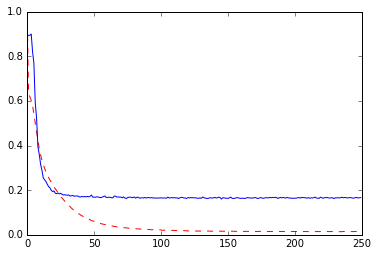

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(tr_cost_sto_bi / max(tr_cost_sto_bi),'r--')
plt.plot(cv_error_sto_bi,'b')
plt.show()

In [13]:
# save to .npz
np.save('sto_binary', [tr_cost_sto_bi, cv_error_sto_bi])